In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

import dask.dataframe as dd

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, DC_COLOR_MAPPINGS, FREQ_GROUPS
from cli import get_file_paths

import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh
import plotting
import pipeline

In [4]:
type_key = 'LF1'
site_key = "Foliage"
# cycle_lengths = [1800, 720, 600, 360, 180, 60, 30, 6]
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

In [5]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]

In [6]:
pipeline_params = dict()
pipeline_params['assemble_location_summary'] = False
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = True
pipeline_params["save_presence_grid"] = True
pipeline_params["save_dc_night_comparisons"] = True
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = False
pipeline_params["show_PST"] = True
pipeline_params

{'assemble_location_summary': False,
 'read_csv': False,
 'save_activity_grid': True,
 'save_presence_grid': True,
 'save_dc_night_comparisons': True,
 'save_activity_dc_comparisons': True,
 'save_presence_dc_comparisons': True,
 'show_plots': False,
 'show_PST': True}

In [7]:
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['resolution_in_min'] = '30'
data_params['recording_start'] = '02:00'
data_params['recording_end'] = '13:30'
data_params

{'site_name': 'Foliage',
 'site_tag': 'Foliage',
 'type_tag': 'LF1',
 'cycle_lengths': [1800, 360],
 'percent_ons': [0.1667],
 'dc_tags': ['1800of1800', '300of1800', '60of360'],
 'cur_dc_tag': '1800of1800',
 'resolution_in_min': '30',
 'recording_start': '02:00',
 'recording_end': '13:30'}

In [8]:
file_paths = get_file_paths(data_params)
file_paths

{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Foliage',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Foliage',
 'bd2_TYPE_SITE_YEAR': 'bd2__LF1Foliage_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Foliage/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_LF1Foliage_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_LF1Foliage_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_LF1Foliage_summary',
 'simulated_schemes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Foliage/duty_cycled/simulated_schemes',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Foliage',
 'activity_det_comparisons_figname': 'activity_det_comparisons_per_dc_LF1Foliage',
 'dc_det_comparisons_figname': 'dc_det_comparisons_per_night_LF1Foliage',
 'activity_bout_comparisons_figname': 'activity_bout_comp

In [9]:
initial_location_df = dh.assemble_initial_location_summary(data_params, file_paths, save=False)

In [10]:
activity_bouts_arr = pd.DataFrame()

# for dc_tag in data_params['dc_tags']:
dc_tag = data_params['dc_tags'][0]
print(dc_tag)
location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
location_sum_df = location_df.copy()
location_sum_df.reset_index(inplace=True)
if 'index' in location_sum_df.columns:
    location_sum_df.drop(columns='index', inplace=True)
location_sum_df

1800of1800


start_time_wrt_ref  end_time_wrt_ref freq_group            ref_time  \
0                 204.4695          204.4856        LF1 2022-06-15 03:30:00   
1                 742.7835          742.7999        LF1 2022-06-15 04:30:00   
2                 744.2315          744.2468        LF1 2022-06-15 04:30:00   
3                 744.7055          744.7217        LF1 2022-06-15 04:30:00   
4                 785.5755          785.5914        LF1 2022-06-15 04:30:00   
...                    ...               ...        ...                 ...   
168872             51.1105           51.1253        LF1 2022-10-17 08:00:00   
168873             51.3365           51.3516        LF1 2022-10-17 08:00:00   
168874             51.5505           51.5650        LF1 2022-10-17 08:00:00   
168875             51.7785           51.7937        LF1 2022-10-17 08:00:00   
168876             52.2485           52.2635        LF1 2022-10-17 08:00:00   

                  call_start_time              call_end_time  start_time  \
0      2022-06-15 03:33:24.469500 2022-06-15 03:33:24.485600    204.4695   
1      2022-06-15 04:42:22.783500 2022-06-15 04:42:22.799900    742.7835   
2      2022-06-15 04:42:24.231500 2022-06-15 04:42:24.246800    744.2315   
3      2022-06-15 04:42:24.705500 2022-06-15 04:42:24.721700    744.7055   
4      2022-06-15 04:43:05.575500 2022-06-15 04:43:05.591400    785.5755   
...                           ...                        ...         ...   
168872 2022-10-17 08:00:51.110500 2022-10-17 08:00:51.125300     51.1105   
168873 2022-10-17 08:00:51.336500 2022-10-17 08:00:51.351600     51.3365   
168874 2022-10-17 08:00:51.550500 2022-10-17 08:00:51.565000     51.5505   
168875 2022-10-17 08:00:51.778500 2022-10-17 08:00:51.793700     51.7785   
168876 2022-10-17 08:00:52.248500 2022-10-17 08:00:52.263500     52.2485   

        end_time  low_freq  high_freq         event              class  \
0       204.4856   18593.0    23399.0  Echolocation   Nyctalus noctula   
1       742.7999   22890.0    26704.0  Echolocation  Nyctalus leisleri   
2       744.2468   22890.0    28244.0  Echolocation  Nyctalus leisleri   
3       744.7217   22890.0    28061.0  Echolocation  Nyctalus leisleri   
4       785.5914   24609.0    29948.0  Echolocation  Nyctalus leisleri   
...          ...       ...        ...           ...                ...   
168872   51.1253   26328.0    30370.0  Echolocation  Nyctalus leisleri   
168873   51.3516   26328.0    29379.0  Echolocation  Nyctalus leisleri   
168874   51.5650   25468.0    30578.0  Echolocation  Nyctalus leisleri   
168875   51.7937   25468.0    29126.0  Echolocation  Nyctalus leisleri   
168876   52.2635   25468.0    29590.0  Echolocation  Nyctalus leisleri   

        class_prob  det_prob  individual  \
0            0.399     0.544          -1   
1            0.520     0.600          -1   
2            0.555     0.660          -1   
3            0.471     0.601          -1   
4            0.328     0.530          -1   
...            ...       ...         ...   
168872       0.460     0.557          -1   
168873       0.543     0.608          -1   
168874       0.388     0.556          -1   
168875       0.529     0.607          -1   
168876       0.486     0.600          -1   

                                               input_file Site name  \
0       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
1       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
2       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
3       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
4       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
...                                                   ...       ...   
168872  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168873  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168874  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168875  /mnt/ubna_

In [11]:
bout_params = dict()
bout_params['site_key'] = data_params['site_tag']
location_sum_df['freq_group'].unique()

array(['LF1'], dtype=object)

In [12]:
# for group in location_sum_df['freq_group'].unique():
#     if group != '':
group = type_key
freq_group_df = location_sum_df.loc[location_sum_df['freq_group']==group].copy()
freq_group_df

start_time_wrt_ref  end_time_wrt_ref freq_group            ref_time  \
0                 204.4695          204.4856        LF1 2022-06-15 03:30:00   
1                 742.7835          742.7999        LF1 2022-06-15 04:30:00   
2                 744.2315          744.2468        LF1 2022-06-15 04:30:00   
3                 744.7055          744.7217        LF1 2022-06-15 04:30:00   
4                 785.5755          785.5914        LF1 2022-06-15 04:30:00   
...                    ...               ...        ...                 ...   
168872             51.1105           51.1253        LF1 2022-10-17 08:00:00   
168873             51.3365           51.3516        LF1 2022-10-17 08:00:00   
168874             51.5505           51.5650        LF1 2022-10-17 08:00:00   
168875             51.7785           51.7937        LF1 2022-10-17 08:00:00   
168876             52.2485           52.2635        LF1 2022-10-17 08:00:00   

                  call_start_time              call_end_time  start_time  \
0      2022-06-15 03:33:24.469500 2022-06-15 03:33:24.485600    204.4695   
1      2022-06-15 04:42:22.783500 2022-06-15 04:42:22.799900    742.7835   
2      2022-06-15 04:42:24.231500 2022-06-15 04:42:24.246800    744.2315   
3      2022-06-15 04:42:24.705500 2022-06-15 04:42:24.721700    744.7055   
4      2022-06-15 04:43:05.575500 2022-06-15 04:43:05.591400    785.5755   
...                           ...                        ...         ...   
168872 2022-10-17 08:00:51.110500 2022-10-17 08:00:51.125300     51.1105   
168873 2022-10-17 08:00:51.336500 2022-10-17 08:00:51.351600     51.3365   
168874 2022-10-17 08:00:51.550500 2022-10-17 08:00:51.565000     51.5505   
168875 2022-10-17 08:00:51.778500 2022-10-17 08:00:51.793700     51.7785   
168876 2022-10-17 08:00:52.248500 2022-10-17 08:00:52.263500     52.2485   

        end_time  low_freq  high_freq         event              class  \
0       204.4856   18593.0    23399.0  Echolocation   Nyctalus noctula   
1       742.7999   22890.0    26704.0  Echolocation  Nyctalus leisleri   
2       744.2468   22890.0    28244.0  Echolocation  Nyctalus leisleri   
3       744.7217   22890.0    28061.0  Echolocation  Nyctalus leisleri   
4       785.5914   24609.0    29948.0  Echolocation  Nyctalus leisleri   
...          ...       ...        ...           ...                ...   
168872   51.1253   26328.0    30370.0  Echolocation  Nyctalus leisleri   
168873   51.3516   26328.0    29379.0  Echolocation  Nyctalus leisleri   
168874   51.5650   25468.0    30578.0  Echolocation  Nyctalus leisleri   
168875   51.7937   25468.0    29126.0  Echolocation  Nyctalus leisleri   
168876   52.2635   25468.0    29590.0  Echolocation  Nyctalus leisleri   

        class_prob  det_prob  individual  \
0            0.399     0.544          -1   
1            0.520     0.600          -1   
2            0.555     0.660          -1   
3            0.471     0.601          -1   
4            0.328     0.530          -1   
...            ...       ...         ...   
168872       0.460     0.557          -1   
168873       0.543     0.608          -1   
168874       0.388     0.556          -1   
168875       0.529     0.607          -1   
168876       0.486     0.600          -1   

                                               input_file Site name  \
0       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
1       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
2       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
3       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
4       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
...                                                   ...       ...   
168872  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168873  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168874  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168875  /mnt/ubna_

In [13]:
# if not(freq_group_df.empty):
ipis_loc, hist_loc = bt_clustering.get_histogram(freq_group_df, 10)
intervals_ms, survival = bt_clustering.get_log_survival(hist_loc)
fast_process = bt_clustering.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = bt_clustering.calculate_exponential_coefficients(fast_process)
slow_process = bt_clustering.regress_around_slow_intervals(intervals_ms, survival)
slow_process = bt_clustering.calculate_exponential_coefficients(slow_process)
nlin_results, misassigned_points_optim = bt_clustering.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
bout_params[f'{group}_bci'] = nlin_results['bci']
bout_params

{'site_key': 'Foliage', 'LF1_bci': 2602.71005605942}

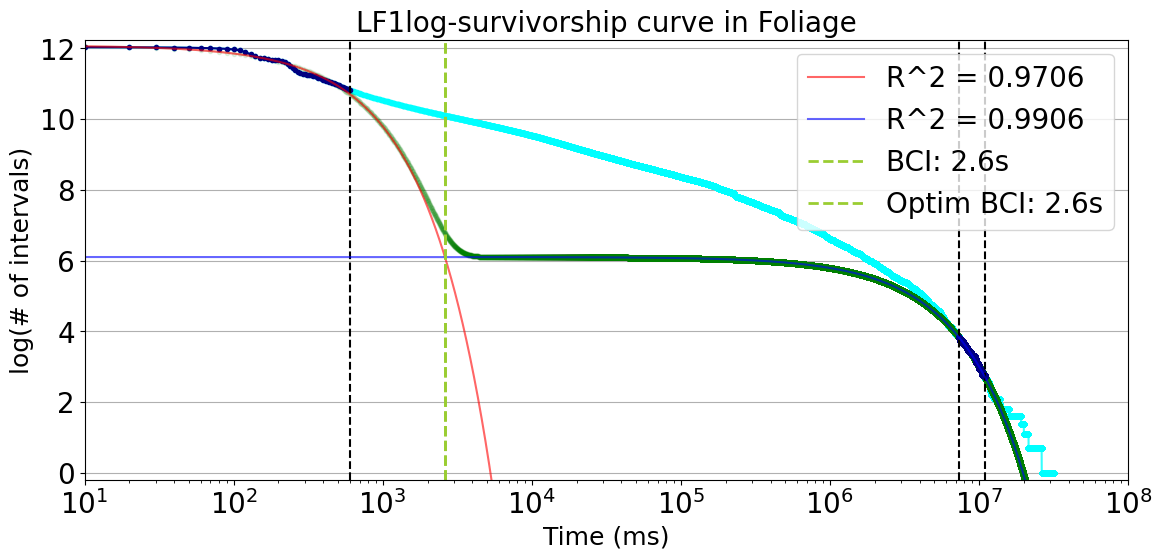

In [14]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = group

bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], nlin_results['bci'], fig_details)

In [15]:
bout_params = bt_clustering.get_bout_params_from_location(location_sum_df, data_params)
bout_params

{'site_key': 'Foliage', 'freq_key': 'LF1', 'LF1_bci': 2602.71005605942}

In [16]:
batdetect2_predictions = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(location_sum_df, bout_params)
batdetect2_predictions[:15]

call_status  change_markers  bout_tag  duration_from_last_call_ms  \
0   outside bout             0.0         0                2.602710e+03   
1     bout start             1.0         0                4.138298e+06   
2    within bout             0.0         1                1.431600e+03   
3       bout end            -1.0         1                4.587000e+02   
4     bout start             1.0         0                4.085380e+04   
5    within bout             0.0         1                1.058100e+03   
6    within bout             0.0         1                2.428000e+02   
7    within bout             0.0         1                1.571000e+02   
8    within bout             0.0         1                2.474000e+02   
9    within bout             0.0         1                4.310000e+02   
10   within bout             0.0         1                1.552000e+02   
11   within bout             0.0         1                2.338000e+02   
12   within bout             0.0         1                1.382000e+02   
13   within bout             0.0         1                1.649000e+02   
14   within bout             0.0         1                1.413000e+02   

    start_time_wrt_ref  end_time_wrt_ref freq_group            ref_time  \
0             204.4695          204.4856        LF1 2022-06-15 03:30:00   
1             742.7835          742.7999        LF1 2022-06-15 04:30:00   
2             744.2315          744.2468        LF1 2022-06-15 04:30:00   
3             744.7055          744.7217        LF1 2022-06-15 04:30:00   
4             785.5755          785.5914        LF1 2022-06-15 04:30:00   
5             786.6495          786.6667        LF1 2022-06-15 04:30:00   
6             786.9095          786.9274        LF1 2022-06-15 04:30:00   
7             787.0845          787.1001        LF1 2022-06-15 04:30:00   
8             787.3475          787.3625        LF1 2022-06-15 04:30:00   
9             787.7935          787.8103        LF1 2022-06-15 04:30:00   
10            787.9655          787.9807        LF1 2022-06-15 04:30:00   
11            788.2145          788.2313        LF1 2022-06-15 04:30:00   
12            788.3695          788.3826        LF1 2022-06-15 04:30:00   
13            788.5475          788.5602        LF1 2022-06-15 04:30:00   
14            788.7015          788.7130        LF1 2022-06-15 04:30:00   

              call_start_time              call_end_time  ...  high_freq  \
0  2022-06-15 03:33:24.469500 2022-06-15 03:33:24.485600  ...    23399.0   
1  2022-06-15 04:42:22.783500 2022-06-15 04:42:22.799900  ...    26704.0   
2  2022-06-15 04:42:24.231500 2022-06-15 04:42:24.246800  ...    28244.0   
3  2022-06-15 04:42:24.705500 2022-06-15 04:42:24.721700  ...    28061.0   
4  2022-06-15 04:43:05.575500 2022-06-15 04:43:05.591400  ...    29948.0   
5  2022-06-15 04:43:06.649500 2022-06-15 04:43:06.666700  ...    29172.0   
6  2022-06-15 04:43:06.909500 2022-06-15 04:43:06.927400  ...    29777.0   
7  2022-06-15 04:43:07.084500 2022-06-15 04:43:07.100100  ...    32867.0   
8  2022-06-15 04:43:07.347500 2022-06-15 04:43:07.362500  ...    30586.0   
9  2022-06-15 04:43:07.793500 2022-06-15 04:43:07.810300  ...    32800.0   
10 2022-06-15 04:43:07.965500 2022-06-15 04:43:07.980700  ...    34462.0   
11 2022-06-15 04:43:08.214500 2022-06-15 04:43:08.231300  ...    33030.0   
12 2022-06-15 04:43:08.369500 2022-06-15 04:43:08.382600  ...    36097.0   
13 2022-06-15 04:43:08.547500 2022-06-15 04:43:08.560200  ...    36823.0   
14 2022-06-15 04:43:08.701500 2022-06-15 04:43:08.713000  ...    36871.0   

           event                class  class_prob det_prob individual  \
0   Echolocation     Nyctalus noctula       0.399    0.544         -1   
1   Echolocation    Nyctalus leisleri       0.520    0.600         -1   
2   Echolocation    Nyctalus leisleri       0.555    0.660         -1   
3   Echolocation    Nyctalus leisleri       0.471    0.601         -1   
4   Echolocation    Nyctalus leisleri

In [17]:
bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_predictions)

time_on = int(dc_tag.split('of')[0])

bt_clustering.test_bout_end_times_in_period(bout_metrics, time_on)

In [18]:
bout_metrics

freq_group            start_time_of_bout           end_time_of_bout  \
0            LF1 2022-06-15 04:42:22.783500000 2022-06-15 04:42:24.721700   
1            LF1 2022-06-15 04:43:05.575500000 2022-06-15 04:43:22.591800   
2            LF1 2022-06-15 04:44:55.963500000 2022-06-15 04:44:56.323100   
3            LF1 2022-06-15 04:45:50.506499999 2022-06-15 04:45:53.863000   
4            LF1 2022-06-15 04:45:57.825500000 2022-06-15 04:46:13.752300   
...          ...                           ...                        ...   
14608        LF1 2022-10-17 05:55:12.176500000 2022-10-17 05:55:19.583000   
14609        LF1 2022-10-17 06:10:00.661500000 2022-10-17 06:10:09.401100   
14610        LF1 2022-10-17 06:20:43.780500000 2022-10-17 06:20:49.474300   
14611        LF1 2022-10-17 06:42:30.291500000 2022-10-17 06:42:35.001500   
14612        LF1 2022-10-17 08:00:47.378500000 2022-10-17 08:00:52.263500   

       start_time_wrt_ref  end_time_wrt_ref  start_time   end_time  low_freq  \
0                742.7835          744.7217    742.7835   744.7217   22890.0   
1                785.5755          802.5918    785.5755   802.5918   23750.0   
2                895.9635          896.3231    895.9635   896.3231   24609.0   
3                950.5065          953.8630    950.5065   953.8630   25468.0   
4                957.8255          973.7523    957.8255   973.7523   23750.0   
...                   ...               ...         ...        ...       ...   
14608           1512.1765         1519.5830   1512.1765  1519.5830   25468.0   
14609            600.6615          609.4011    600.6615   609.4011   25468.0   
14610           1243.7805         1249.4743   1243.7805  1249.4743   26328.0   
14611            750.2915          755.0015    750.2915   755.0015   25468.0   
14612             47.3785           52.2635     47.3785    52.2635   24609.0   

       high_freq             bout_duration  bout_duration_in_secs  
0        28244.0    0 days 00:00:01.938200                 1.9382  
1        49983.0    0 days 00:00:17.016300                17.0163  
2        30259.0    0 days 00:00:00.359600                 0.3596  
3        36167.0 0 days 00:00:03.356500001                 3.3565  
4        48849.0    0 days 00:00:15.926800                15.9268  
...          ...                       ...                    ...  
14608    34634.0    0 days 00:00:07.406500                 7.4065  
14609    34996.0    0 days 00:00:08.739600                 8.7396  
14610    34586.0    0 days 00:00:05.693800                 5.6938  
14611    30527.0    0 days 00:00:04.710000                 4.7100  
14612    31237.0    0 days 00:00:04.885000                 4.8850  

[14613 rows x 11 columns]

In [19]:
bout_metrics = bt_clustering.generate_bout_metrics_for_location_and_freq(location_df, data_params, dc_tag)
bout_metrics

freq_group            start_time_of_bout           end_time_of_bout  \
0            LF1 2022-06-15 04:42:22.783500000 2022-06-15 04:42:24.721700   
1            LF1 2022-06-15 04:43:05.575500000 2022-06-15 04:43:22.591800   
2            LF1 2022-06-15 04:44:55.963500000 2022-06-15 04:44:56.323100   
3            LF1 2022-06-15 04:45:50.506499999 2022-06-15 04:45:53.863000   
4            LF1 2022-06-15 04:45:57.825500000 2022-06-15 04:46:13.752300   
...          ...                           ...                        ...   
14608        LF1 2022-10-17 05:55:12.176500000 2022-10-17 05:55:19.583000   
14609        LF1 2022-10-17 06:10:00.661500000 2022-10-17 06:10:09.401100   
14610        LF1 2022-10-17 06:20:43.780500000 2022-10-17 06:20:49.474300   
14611        LF1 2022-10-17 06:42:30.291500000 2022-10-17 06:42:35.001500   
14612        LF1 2022-10-17 08:00:47.378500000 2022-10-17 08:00:52.263500   

       start_time_wrt_ref  end_time_wrt_ref  start_time   end_time  low_freq  \
0                742.7835          744.7217    742.7835   744.7217   22890.0   
1                785.5755          802.5918    785.5755   802.5918   23750.0   
2                895.9635          896.3231    895.9635   896.3231   24609.0   
3                950.5065          953.8630    950.5065   953.8630   25468.0   
4                957.8255          973.7523    957.8255   973.7523   23750.0   
...                   ...               ...         ...        ...       ...   
14608           1512.1765         1519.5830   1512.1765  1519.5830   25468.0   
14609            600.6615          609.4011    600.6615   609.4011   25468.0   
14610           1243.7805         1249.4743   1243.7805  1249.4743   26328.0   
14611            750.2915          755.0015    750.2915   755.0015   25468.0   
14612             47.3785           52.2635     47.3785    52.2635   24609.0   

       high_freq             bout_duration  bout_duration_in_secs  
0        28244.0    0 days 00:00:01.938200                 1.9382  
1        49983.0    0 days 00:00:17.016300                17.0163  
2        30259.0    0 days 00:00:00.359600                 0.3596  
3        36167.0 0 days 00:00:03.356500001                 3.3565  
4        48849.0    0 days 00:00:15.926800                15.9268  
...          ...                       ...                    ...  
14608    34634.0    0 days 00:00:07.406500                 7.4065  
14609    34996.0    0 days 00:00:08.739600                 8.7396  
14610    34586.0    0 days 00:00:05.693800                 5.6938  
14611    30527.0    0 days 00:00:04.710000                 4.7100  
14612    31237.0    0 days 00:00:04.885000                 4.8850  

[14613 rows x 11 columns]

In [20]:
dc_bouts = dh.construct_activity_arr_from_bout_metrics(bout_metrics, data_params, file_paths, dc_tag)
dc_bouts = dc_bouts.set_index("Date_and_Time_UTC")

In [21]:
def construct_activity_arr_from_bout_metrics(bout_metrics, data_params, file_paths, dc_tag):
    all_processed_filepaths = sorted(list(map(str, list(Path(f'{file_paths["raw_SITE_folder"]}').glob('*.csv')))))
    all_processed_datetimes = pd.to_datetime(all_processed_filepaths, format="%Y%m%d_%H%M%S", exact=False)

    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bout_metrics['total_bout_duration_in_secs'] = bout_metrics['bout_duration_in_secs']
    bout_metrics = bout_metrics.set_index('ref_time')

    bout_duration_per_interval = bout_metrics.resample(f"{data_params['resolution_in_min']}T")['total_bout_duration_in_secs'].sum()

    time_occupied_by_bouts  = bout_duration_per_interval.values
    percent_time_occupied_by_bouts = (100*(time_occupied_by_bouts / (60*float(data_params['resolution_in_min']))))

    bout_dpi_df = pd.DataFrame(list(zip(bout_duration_per_interval.index, time_occupied_by_bouts)), columns=['ref_time', f'percentage_time_occupied_by_bouts ({dc_tag})'])
    bout_dpi_df = bout_dpi_df.set_index('ref_time')
    bout_dpi_df = bout_dpi_df.reindex(index=all_processed_datetimes, fill_value=0).resample(f"{data_params['resolution_in_min']}T").first().between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

    return pd.DataFrame(list(zip(bout_dpi_df.index, bout_dpi_df[f'percentage_time_occupied_by_bouts ({dc_tag})'].values)), columns=["Date_and_Time_UTC", f'percentage_time_occupied_by_bouts ({dc_tag})'])

def generate_bout_metrics_for_location_and_freq(location_sum_df, data_params, dc_tag):

    location_sum_df.reset_index(inplace=True)
    if 'index' in location_sum_df.columns:
        location_sum_df.drop(columns='index', inplace=True)
    resampled_df = location_sum_df.resample(f'1800S', on='ref_time')
    location_sum_df['ref_time'] = resampled_df['ref_time'].transform(lambda x: x.name)

    bout_params = bt_clustering.get_bout_params_from_location(location_sum_df, data_params)

    batdetect2_predictions = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(location_sum_df, bout_params)
    bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_predictions)

    time_on = int(dc_tag.split('of')[0])

    bt_clustering.test_bout_end_times_in_period(bout_metrics, time_on)

    return bout_metrics

In [22]:
activity_bouts_arr = pd.DataFrame()

dc_tag = '1800of1800'
location_df_c = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
freq_groups = location_df_c['freq_group'].unique()
assert(len(freq_groups)==1 and freq_groups[0] == 'LF1')
bout_metrics_c = bt_clustering.generate_bout_metrics_for_location_and_freq(location_df_c, data_params, dc_tag)
time_cond = np.logical_and((pd.DatetimeIndex(bout_metrics_c['start_time_of_bout']).time >= dt.time(9, 30, 0)),
                           (pd.DatetimeIndex(bout_metrics_c['start_time_of_bout']).time <= dt.time(10, 0, 0)))
datetime_cond = np.logical_and((pd.DatetimeIndex(bout_metrics_c['start_time_of_bout']).date == dt.date(2022, 7, 25)), time_cond)
bout_metrics_c.loc[datetime_cond]

freq_group         start_time_of_bout           end_time_of_bout  \
7896        LF1 2022-07-25 09:33:01.957500 2022-07-25 09:33:04.494200   
7897        LF1 2022-07-25 09:36:04.261500 2022-07-25 09:36:05.554700   
7898        LF1 2022-07-25 09:54:09.300500 2022-07-25 09:54:17.888900   

      start_time_wrt_ref  end_time_wrt_ref  start_time   end_time  low_freq  \
7896            181.9575          184.4942    181.9575   184.4942   17734.0   
7897            364.2615          365.5547    364.2615   365.5547   27187.0   
7898           1449.3005         1457.8889   1449.3005  1457.8889   22031.0   

      high_freq          bout_duration  bout_duration_in_secs  
7896    25760.0 0 days 00:00:02.536700                 2.5367  
7897    29951.0 0 days 00:00:01.293200                 1.2932  
7898    28791.0 0 days 00:00:08.588400                 8.5884

In [23]:
dc_tag = '300of1800'
location_df_dc1 = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
freq_groups = location_df_dc1['freq_group'].unique()
assert(len(freq_groups)==1 and freq_groups[0] == 'LF1')
bout_metrics_dc1 = bt_clustering.generate_bout_metrics_for_location_and_freq(location_df_dc1, data_params, dc_tag)
time_cond = np.logical_and((pd.DatetimeIndex(bout_metrics_dc1['start_time_of_bout']).time >= dt.time(9, 30, 0)),
                           (pd.DatetimeIndex(bout_metrics_dc1['start_time_of_bout']).time <= dt.time(10, 0, 0)))
datetime_cond = np.logical_and((pd.DatetimeIndex(bout_metrics_dc1['start_time_of_bout']).date == dt.date(2022, 7, 25)), time_cond)
bout_metrics_dc1.loc[datetime_cond]

freq_group         start_time_of_bout           end_time_of_bout  \
1253        LF1 2022-07-25 09:33:01.957500 2022-07-25 09:33:04.494200   

      start_time_wrt_ref  end_time_wrt_ref  start_time  end_time  low_freq  \
1253            181.9575          184.4942    181.9575  184.4942   17734.0   

      high_freq          bout_duration  bout_duration_in_secs  
1253    25760.0 0 days 00:00:02.536700                 2.5367

In [24]:
dc_tag = '60of360'
location_df_dc2 = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
freq_groups = location_df_dc2['freq_group'].unique()
assert(len(freq_groups)==1 and freq_groups[0] == 'LF1')
bout_metrics_dc2 = generate_bout_metrics_for_location_and_freq(location_df_dc2, data_params, dc_tag)
time_cond = np.logical_and((pd.DatetimeIndex(bout_metrics_dc2['start_time_of_bout']).time >= dt.time(9, 30, 0)),
                           (pd.DatetimeIndex(bout_metrics_dc2['start_time_of_bout']).time <= dt.time(10, 0, 0)))
datetime_cond = np.logical_and((pd.DatetimeIndex(bout_metrics_dc2['start_time_of_bout']).date == dt.date(2022, 7, 25)), time_cond)
bout_metrics_dc2.loc[datetime_cond]

freq_group         start_time_of_bout           end_time_of_bout  \
1415        LF1 2022-07-25 09:36:04.261500 2022-07-25 09:36:05.554700   
1416        LF1 2022-07-25 09:54:06.607500 2022-07-25 09:54:17.888900   

      start_time_wrt_ref  end_time_wrt_ref  start_time   end_time  low_freq  \
1415              4.2615            5.5547    364.2615   365.5547   27187.0   
1416              6.6075           17.8889   1446.6075  1457.8889   22031.0   

      high_freq          bout_duration  bout_duration_in_secs  
1415    29951.0 0 days 00:00:01.293200                 1.2932  
1416    28791.0 0 days 00:00:11.281400                11.2814

In [25]:
activity_bouts_arr = pd.DataFrame()

for dc_tag in data_params['dc_tags']:

    location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
    bout_metrics = bt_clustering.generate_bout_metrics_for_location_and_freq(location_df, data_params, dc_tag)
    dc_bouts = dh.construct_activity_arr_from_bout_metrics(bout_metrics, data_params, file_paths, dc_tag)
    dc_bouts = dc_bouts.set_index("Date_and_Time_UTC")
    activity_bouts_arr = pd.concat([activity_bouts_arr, dc_bouts], axis=1)

In [26]:
continuous_column = ''
for column in activity_bouts_arr.columns:
    if ('1800of1800') in column:
        continuous_column = column

continuous_metrics = activity_bouts_arr[continuous_column].dropna()
continuous_metrics

Date_and_Time_UTC
2022-06-15 02:00:00    0.0
2022-06-15 02:30:00    0.0
2022-06-15 03:00:00    0.0
2022-06-15 03:30:00    0.0
2022-06-15 04:00:00    0.0
                      ... 
2022-10-17 11:00:00    0.0
2022-10-17 11:30:00    0.0
2022-10-17 12:00:00    0.0
2022-10-17 12:30:00    0.0
2022-10-17 13:00:00    0.0
Name: percentage_time_occupied_by_bouts (1800of1800), Length: 2604, dtype: float64

In [27]:
# for column in activity_bouts_arr.columns:
columns = activity_bouts_arr.columns[1]
dc_metrics = activity_bouts_arr[column].dropna()
dc_metrics

Date_and_Time_UTC
2022-06-15 02:00:00    0.0
2022-06-15 02:30:00    0.0
2022-06-15 03:00:00    0.0
2022-06-15 03:30:00    0.0
2022-06-15 04:00:00    0.0
                      ... 
2022-10-17 11:00:00    0.0
2022-10-17 11:30:00    0.0
2022-10-17 12:00:00    0.0
2022-10-17 12:30:00    0.0
2022-10-17 13:00:00    0.0
Name: percentage_time_occupied_by_bouts (60of360), Length: 2604, dtype: float64

In [28]:
assertion = (dc_metrics<=continuous_metrics).values
np.where(assertion==False)[0]

array([ 764, 2478])

In [29]:
(activity_bouts_arr.dropna()).iloc[np.where(assertion==False)[0]]

percentage_time_occupied_by_bouts (1800of1800)  \
Date_and_Time_UTC                                                     
2022-07-25 09:30:00                                        0.689906   
2022-10-12 08:00:00                                        0.353022   

                     percentage_time_occupied_by_bouts (300of1800)  \
Date_and_Time_UTC                                                    
2022-07-25 09:30:00                                       0.140928   
2022-10-12 08:00:00                                       0.498872   

                     percentage_time_occupied_by_bouts (60of360)  
Date_and_Time_UTC                                                 
2022-07-25 09:30:00                                     0.698589  
2022-10-12 08:00:00                                     0.498872

In [31]:
activity_bouts_arr[-23:]

percentage_time_occupied_by_bouts (1800of1800)  \
Date_and_Time_UTC                                                     
2022-10-17 02:00:00                                        0.653728   
2022-10-17 02:30:00                                        0.000000   
2022-10-17 03:00:00                                        0.390139   
2022-10-17 03:30:00                                        1.077556   
2022-10-17 04:00:00                                        0.796228   
2022-10-17 04:30:00                                        0.452600   
2022-10-17 05:00:00                                        0.390300   
2022-10-17 05:30:00                                        1.011378   
2022-10-17 06:00:00                                        0.801856   
2022-10-17 06:30:00                                        0.261667   
2022-10-17 07:00:00                                        0.000000   
2022-10-17 07:30:00                                        0.000000   
2022-10-17 08:00:00                                        0.271389   
2022-10-17 08:30:00                                        0.000000   
2022-10-17 09:00:00                                        0.000000   
2022-10-17 09:30:00                                        0.000000   
2022-10-17 10:00:00                                        0.000000   
2022-10-17 10:30:00                                        0.000000   
2022-10-17 11:00:00                                        0.000000   
2022-10-17 11:30:00                                        0.000000   
2022-10-17 12:00:00                                        0.000000   
2022-10-17 12:30:00                                        0.000000   
2022-10-17 13:00:00                                        0.000000   

                     percentage_time_occupied_by_bouts (300of1800)  \
Date_and_Time_UTC                                                    
2022-10-17 02:00:00                                       0.000000   
2022-10-17 02:30:00                                       0.000000   
2022-10-17 03:00:00                                       0.000000   
2022-10-17 03:30:00                                       0.649372   
2022-10-17 04:00:00                                       0.296100   
2022-10-17 04:30:00                                       0.000000   
2022-10-17 05:00:00                                       0.000000   
2022-10-17 05:30:00                                       0.000000   
2022-10-17 06:00:00                                       0.000000   
2022-10-17 06:30:00                                       0.000000   
2022-10-17 07:00:00                                       0.000000   
2022-10-17 07:30:00                                       0.000000   
2022-10-17 08:00:00                                       0.271389   
2022-10-17 08:30:00                                       0.000000   
2022-10-17 09:00:00                                       0.000000   
2022-10-17 09:30:00                                       0.000000   
2022-10-17 10:00:00                                       0.000000   
2022-10-17 10:30:00                                       0.000000   
2022-10-17 11:00:00                                       0.000000   
2022-10-17 11:30:00                                       0.000000   
2022-10-17 12:00:00                                       0.000000   
2022-10-17 12:30:00                                       0.000000   
2022-10-17 13:00:00                                       0.000000   

                     percentage_time_occupied_by_bouts (60of360)  
Date_and_Time_UTC                                                 
2022-10-17 02:00:00                                     0.313989  
2022-10-17 02:30:00                                     0.000000  
2022-10-17 03:00:00                                     0.000000  
2022-10-17 03:30:00                                     0.481478  
2022-10-17 04:00:00                                     0.000000  
2022-10-17 04:30:00      

In [32]:
activity_bouts_arr = pipeline.run_for_bouts(data_params, pipeline_params, file_paths)

In [33]:
plotting.plot_activity_grid_for_bouts(dh.construct_activity_grid_for_bouts(activity_bouts_arr, data_params['cur_dc_tag']), data_params, pipeline_params, file_paths)
# plotting.plot_dc_bouts_comparisons_per_night(activity_bouts_arr, data_params, pipeline_params, file_paths)

In [ ]:
plotting.plot_dc_bout_activity_comparisons_per_scheme(activity_bouts_arr, data_params, pipeline_params, file_paths)

In [ ]:
# pipeline.plot_bouts(activity_bouts_arr, data_params, pipeline_params, file_paths)

In [ ]:
# pipeline.compare_bout_and_det_metrics(data_params, pipeline_params, file_paths)